In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/yandex/open_task/open_task/qid_query.tsv
/kaggle/input/yandex/open_task/open_task/qid_url_rating.tsv
/kaggle/input/yandex/open_task/open_task/hostid_url.tsv
/kaggle/input/yandex/hidden_task/qid_query.tsv
/kaggle/input/yandex/hidden_task/qid_url_rating.tsv
/kaggle/input/yandex/hidden_task/hostid_url.tsv


# PFound

Исходные данные - Yandex Cup 2022 Analytics

    Ссылка - https://yandex.ru/cup/analytics/analysis/ , пример A. Рассчитать pFound
    Данные - https://yadi.sk/d/guqki4UI4hFlXQ

В архиве содержится три текстовых файла:

    qid_query.tsv — id запроса и текст запроса, разделённые табуляцией;
    qid_url_rating.tsv — id запроса, URL документа, релевантность документа запросу;
    hostid_url.tsv — id хоста и URL документа.
Задача - написать функцию, которая принимает на вход dataframe (после join), а на выходе дает средний pFound по всем query.
Нужно вывести текст запроса с максимальным значением метрики , посчитанной по топ-10 документов.
Если для запроса есть несколько документов с одним и тем же id хоста — оставить только максимально релевантный документ (а если несколько документов максимально релевантны, выбрать любой).
Документы по запросу сортируются по убыванию релевантности после выбора одного документа для хоста. Если у нескольких документов с разных хостов релевантность одинакова, их порядок может быть произвольным.
Формула для расчёта

:
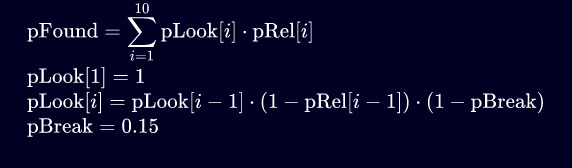

    Запрещается использовать циклы for для расчет метрики (как полностью, так и ее частей).

In [2]:
qid_query = pd.read_csv(f"/kaggle/input/yandex/open_task/open_task/qid_query.tsv", sep="\t", names=["qid", "query"])
qid_url_rating = pd.read_csv(f"/kaggle/input/yandex/open_task/open_task/qid_url_rating.tsv", sep="\t", names=["qid", "url", "rating"])
hostid_url = pd.read_csv(f"/kaggle/input/yandex/open_task/open_task/hostid_url.tsv", sep="\t", names=["hostid", "url"])

In [3]:
qid_query.head(10)

,qid,query
0,10387,batman arkham city будет русский перевод?
1,107538,Список белорусской литературы по лизингу
2,150126,написание review
3,168170,медаль в подарок на 30 лет
4,176370,что означает рожь и пшеница годом родится а ве...
5,192007,должностная инструкция главного технолога моло...
6,20860,в египетской мифологии богиня-львица
7,21070,теория Лаунхардта
8,213932,6 класс география почему в географическую обол...
9,221830,семья


In [4]:
qid_url_rating

,qid,url,rating
0,10387,http://batman-arkhamcity.ru/,0.00
1,10387,http://bigtorrents.org/publ/batman_arkham_city...,0.14
2,10387,http://consolelife.ru/xbox-360/6577-o-rossiysk...,0.14
3,10387,http://dic.academic.ru/book.nsf/3662736/Batman...,0.00
4,10387,http://forum.csmania.ru/viewtopic.php?t=25986,0.14
...,...,...,...
849,380923,http://www.spishy.ru/referats/14/8040,0.00
850,380923,http://www.sprinter.ru/books/1821345.html,0.00
851,380923,http://www.twirpx.com/files/mathematics/algebr...,0.00
852,380923,http://wzyocgeawwo.eklablog.com/2-a60036325,0.00


In [5]:
hostid_url

,hostid,url
0,100,http://cons66.ru/
1,1000,http://www.pozdravleniya.biz/stihi/detskie/
2,1001,http://www.pravda.ru/society/family/pbringing/...
3,1002,http://www.pravpiter.ru/gorn/n015/ta003.htm
4,1003,http://www.pregnancycalendar.ru/biblioteka/vse...
...,...,...
849,997,http://www.portalus.ru/modules/economics/rus_r...
850,997,http://www.portalus.ru/modules/economics/rus_r...
851,997,http://www.portalus.ru/modules/economics/rus_s...
852,998,http://www.poskart.ru/dobrij-prigoditsa.html


In [6]:
hostid_url_qid_url_rating = pd.merge(qid_url_rating, hostid_url, on="url")

# Решение с циклом

In [7]:
def plook(ind, rels):
    if ind == 0:
        return 1
    return plook(ind - 1, rels) * (1 - rels[ind - 1]) * (1 - 0.15)
def pfound(group):
    max_by_host = group.groupby("hostid")["rating"].max()
    top_10 = max_by_host.sort_values(ascending=False).head(10)
    pfound = 0
    for ind, val in enumerate(top_10):
        pfound +=  val * plook(ind, top_10.values)
    return pfound

In [8]:
qid_pfound = hostid_url_qid_url_rating.groupby('qid').apply(pfound)
qid_max = qid_pfound.idxmax()

In [9]:
qid_query[qid_query["qid"] == qid_max]

,qid,query
12,295761,гугл переводчик


In [10]:
qid_pfound.mean()

0.4603173929969002

# Решение без цикла

In [11]:
def pFound(
    df: pd.DataFrame,
    k: int = 10,
    p_break: float = 0.15) -> float:
    
    # найдем максимально релевантный документ в каждом хосте и отсортируем хосты в каждом запросе по убыванию
    qid_hostid_max_rating = df.groupby(['qid', 'hostid'])['rating'].max().reset_index()
    sorted_qid = qid_hostid_max_rating.sort_values(['qid', 'rating'], ascending=False)
    
    # найдем топ-k хостов в каждом запросе
    sorted_qid_top_k = sorted_qid.groupby(['qid']).head(k)
    
    top_k = sorted_qid_top_k.copy()
    
    # добавим вспомогательные столбцы с промежуточными результатами расчета
    top_k['1 - pBreak'] = 1 - p_break
    top_k['1 - pRel'] = (1 - top_k['rating']).shift(1)
    top_k['sorted_num'] = top_k.groupby('qid').cumcount()
    
    # изменим первые значения на (1) 
    top_k.loc[top_k['sorted_num'] == 0, ['1 - pRel', '1 - pBreak']] = 1
     
    # рассчитаем pLook
    top_k['prod'] = top_k['1 - pRel'] * top_k['1 - pBreak']
    top_k['pLook'] = top_k.groupby('qid')['prod'].cumprod()
    
    # найдем значение pFound для каждого host, а затем для qid
    top_k['pFound'] = top_k['pLook'] * top_k['rating']
    pFound = top_k.groupby('qid')['pFound'].sum()
    
    return pFound.mean()


    
    
    

In [12]:
# решение 1
%timeit qid_pFound = hostid_url_qid_url_rating.groupby('qid').apply(pfound)

13.7 ms ± 96.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
qid_pfound.mean()

0.4603173929969002

In [14]:
# решение без цикла
%timeit qid_pFound_new = pFound(hostid_url_qid_url_rating)

9.24 ms ± 142 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
qid_pFound_new = pFound(hostid_url_qid_url_rating)
qid_pFound_new

0.4603173929969002

Решение без цикла оказалось намного эффективнее